# Notebook to identify the neural invariance manifold of macaque V1 complex cells


---

### Imports and config parameters



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
from classicalv1.toy_models import RotationInvariantGabor, RotationInvariantComplex, ComplexCell
from invariance_generation.datamodule import JitteringGridDatamodule
from invariance_generation.cppn import CPPNForInvariances
from invariance_generation.regularization import SimCLROnGrid
from invariance_generation.utils.plot_utils import plot_f, plot_filters
import os
import math
from PIL import Image
import glob
import matplotlib
from invariance_generation.models import get_model, ensamble
import torch 
import torch.nn as nn
from invariance_generation.utils.img_transf import StandardizeClip


font = {'size'   : 20}
matplotlib.rc('font', **font)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
with_periodic_invariances = True 
temperature =  0.3
reg_coefs = [1, 0.5]
epochs_per_reg = 10
lr = 1e-2
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)


### Load pretrained ensamble model and select neuron
Neurons in the used model are characterized by a data key (corresponding to experimental session) and a index


In [2]:
class monkey_ensamble_model(nn.Module):
    def __init__(self, models_paths, data_key, index):
        super().__init__()
        self.models_paths = models_paths
        self.data_key = data_key
        self.index = index
        models =[]
        for path in models_paths:
            model = get_model(seed=1)
            model.load_state_dict(torch.load(path))
            models.append(model)
        self.models = nn.ModuleList(models)
        self.training = False
        
    def forward(self, x):
        output = torch.stack([model(x, self.data_key) for model in self.models], dim=0).mean(dim=0)[:, self.index]
        return output

models_path_list = [
    '/project/notebooks/macaqueV1/presaved_models/monkey_model10.pt',
    '/project/notebooks/macaqueV1/presaved_models/monkey_model3.pt',
    '/project/notebooks/macaqueV1/presaved_models/monkey_model12.pt',
]

cell_name = "A" #choose between A, B, C"

if cell_name == "A":
    IDX = 356
    data_key = '3639406161189'
    index = 11
    MEI_activation = 17.06
if cell_name == "B":
    IDX = 456
    data_key = '3631807112901'
    index = 27
    MEI_activation = 19.905
if cell_name == "C":
    IDX = 358
    data_key = '3639406161189'
    index = 13
    MEI_activation = 23.966

encoding_model = monkey_ensamble_model(models_path_list, data_key, index).to(device)

### Initialize CPPN

The CPPN is an MLP that create images depending on an input parameter z (latent) predicting pixel values from x and y coordinates

In [3]:
cppn_config = dict(    
    img_res=[93,93],
    channels=1,
    positional_encoding_dim=10,
    positional_encoding_projection_scale=1.,
    num_neurons=1,
    num_invariances=1,
    with_periodic_invariances=with_periodic_invariances,
    nonlinearity=nn.LeakyReLU,
    weights_scale=.1,
    batchnorm=True,
    bias=True,
    aux_dim_scale=1.
)
cppn = CPPNForInvariances(**cppn_config).to(device)

### Intermediate image transformation 

fix mean and standard deviation (luminance and contrast) before passing images to the neural response model

In [4]:
std = 0.15
mean = 0.2022
pixel_min = -1.7876
pixel_max = 2.1919
img_transf_config = dict(mean=mean, std=std, pixel_min=pixel_min, pixel_max=pixel_max)
img_transforms = StandardizeClip(**img_transf_config).to(device)

### Dataloader to load latent grid 

This module sample the grid of points in the latent space from which to create images at each training step

In [5]:
dataloader_config = dict(
    num_invariances=1,
    grid_points_per_dim=20, 
    steps_per_epoch=50, 
)
dm = JitteringGridDatamodule(**dataloader_config)
dm.train_dataloader()
grid = dm.grid.to(device)

### Constrastive learning objective module

This object define positive and negative points for each point in the grid and changes depending on latent space topology

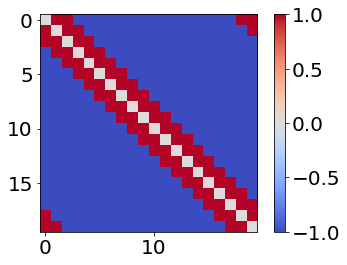

In [6]:
objective_config = dict(
    num_invariances=1,
    grid_points_per_dim=20,
    neighbor_size=.1,
    temperature = temperature,
    with_periodic_invariances=with_periodic_invariances,
    with_round_neighbor = False
)

grid_reg = SimCLROnGrid(**objective_config).to(device)
ax = plot_f(grid_reg.neighbor_mask, return_plt=True)

### Create a forward function 

It feeds point to CPPN to create images, fixes their luminance and contrast and pass them to the neural model to get activations

In [7]:
def forward(grid, cppn, img_tranfs, encoding_model, resolution_increase_factor=1.):
    """forward pass throught the pipeline """
    img_pre = cppn(grid)
    img_post = img_tranfs(img_pre)
    acts = encoding_model(img_post)
    
    if resolution_increase_factor > 1:
        with torch.no_grad():
            img_pre_hres = cppn(grid, img_res=[r*resolution_increase_factor for r in cppn.img_res])
            img_post_hres = img_transforms(img_pre_hres)       
    else:
        img_post_hres = img_post
    
    return img_pre, img_post, acts, img_post_hres

## Train the generative model 

The cppn is trained to maximaxe activation and produce different images with a constrastive regularization term with a regularization strength decreasing schedule

In [8]:
for reg_idx, reg_scale in enumerate(reg_coefs):
    num_epochs = epochs_per_reg
    optimizer = torch.optim.Adam(cppn.parameters(), lr=lr)
    pbar = tqdm(range(num_epochs), desc='mean activation will appear after one epoch')
    encoding_model.eval()
    for epoch in pbar:
        # Training
        cppn.train()
        for input_grid in dm.train_dataloader():
            input_grid = input_grid.to(device)
            img_pre, img_post, _acts, _ = forward(input_grid, cppn, img_transforms, encoding_model)
            acts = _acts/MEI_activation
            loss = -acts.mean() - reg_scale * grid_reg.reg_term(img_post)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description(f"Act = {acts.mean().item():.2f} | Reg ({reg_idx+1}/{len(reg_coefs)}) = {reg_scale}")

Act = 0.91 | Reg (1/2) = 1: 100%|██████████| 10/10 [00:32<00:00,  3.25s/it]        
Act = 0.98 | Reg (2/2) = 0.5: 100%|██████████| 10/10 [00:32<00:00,  3.23s/it]      


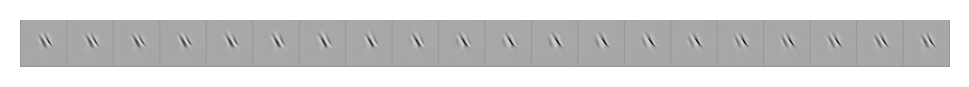

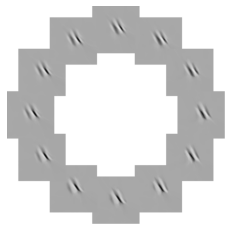

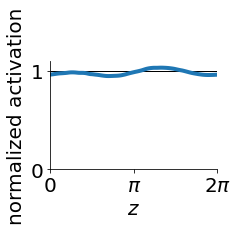

In [9]:
cell_name = f'complex_cell/temp_' + str(temperature)
with torch.no_grad():
    # plot flat
    n = 9
    grid = torch.linspace(0, 2*np.pi, n+1, )[:n].reshape(n, 1).to(device)
    encoding_model.eval()
    img_pre, img_post, acts, _ = forward(grid, cppn, img_transforms, encoding_model=encoding_model)
    name = "/project/plots/1D/"
    path = name + cell_name + "/flat_image/"
    os.makedirs(path, exist_ok=True)
    extreme = torch.max(torch.abs(img_post))
    plot_filters(img_post, nrow=n,  vmin=-extreme, vmax=extreme, cmap='Greys_r' )
    plt.axis('off')
    plt.savefig(f'{path}/flat.png', bbox_inches='tight', pad_inches = 0)
    plt.show()

      # plot in circle
    def arrangeImagesInCircle(masterImage, imagesToArrange):
        imgWidth, imgHeight = masterImage.size
        diameter = min(
            imgWidth  - max(img.size[0] for img in imagesToArrange),
            imgHeight - max(img.size[1] for img in imagesToArrange)
        )
        radius = diameter / 2
        circleCenterX = imgWidth  / 2
        circleCenterY = imgHeight / 2
        theta = 2*math.pi / len(imagesToArrange)
        for i, curImg in enumerate(imagesToArrange):
            angle = i * theta
            dx = int(radius * math.sin(angle))
            dy = -int(radius * math.cos(angle))
            pos = (
                int(circleCenterX + dx - curImg.size[0]/2),
                int(circleCenterY + dy - curImg.size[1]/2),
            )
            masterImage.paste(curImg, pos)
        return img

    grid = torch.linspace(0, 2*np.pi, 13, )[:12].reshape(12, 1).to(device)
    encoding_model.eval()
    img_pre, img_post, acts, _ = forward(grid, cppn, img_transforms, encoding_model=encoding_model)
    name = "/project/plots/1D/"
    path = name + cell_name 
    os.makedirs(path, exist_ok=True)
    for i in range(0, 12):
        plt.imshow(img_post.detach().cpu().numpy()[i, 0],  vmin=-extreme, vmax=extreme, cmap='Greys_r')
        plt.axis('off')
        plt.savefig(f'{path}/{i:02d}.png', bbox_inches='tight', pad_inches = 0)
    img = Image.new("RGB", (1000,1000), (255,255,255))
    folder = path + "/circle_image/"
    os.makedirs(folder, exist_ok=True)
    imageFilenames = glob.glob(f'{path}/*.png')
    imageFilenames = sorted(imageFilenames)
    images = [Image.open(filename) for filename in imageFilenames]
    IMG = arrangeImagesInCircle(img, images)
    IMG.save(f'{folder}/circle.png')
    plt.imshow(IMG)

    # activation
    n = 100
    grid = torch.linspace(0, 2*np.pi, n+1 )[:n].reshape(n, 1).to(device)
    encoding_model.eval()
    img_pre, img_post, acts, _ = forward(grid, cppn, img_transforms, encoding_model=encoding_model)
    acts = acts/MEI_activation
    name = "/project/plots/1D/"
    path = name  + cell_name + "/activation/" 
    os.makedirs(path, exist_ok=True)
    fix, ax = plt.subplots(1, 1, figsize=(3,2))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    plt.ylabel('normalized activation')
    plt.xlabel(r'$z$')
    ax.hlines(1, 0, 2*np.pi, linewidth=1)
    ax.plot(grid.detach().cpu().squeeze().numpy(), acts.detach().cpu().squeeze().numpy(),  linewidth=4)
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 2*np.pi)
    ax.set_xticks([0,np.pi, 2*np.pi])
    ax.set_xticklabels(['0', r'$\pi$', r'2$\pi$'])
    plt.savefig(path + 'act.svg',  bbox_inches='tight', transparent=False)
    plt.show()
